In [1]:
# Install torch geometric -- for pyg
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import pickle
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Building the SkyNet Dataset

We load our preprocessed flight-delay graphs using a custom `SkyNetDataset` class.
Each graph represents a **6-hour block** of the US flight network, where:

- **Nodes** = Airports (with geographic & weather features)
- **Edges** = Individual flights (with scheduling & operational features)
- **Labels** = Departure delays for each flight (regression target)

We support two evaluation modes:

- **Month Split**  
  - Train on **Jan–Sep**  
  - Test on **Oct–Dec**
- **Random 80/20 Split**  
  - Merge all individual graphs
  - Mask 20% of the edges for test time.
  - Train on the other 80% random edges.

This ensures we evaluate **temporal generalization** rather than random splits.

In this notebook, we will just utililize the monthly split because this is an ablation study to see what happens if we exclude tailnumber data from our GCN edges.

In [4]:
class SkyNetDataset(InMemoryDataset):
    def __init__(self, root, mode='month_split', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.mode = mode

        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        data_list = [self.get(i) for i in range(len(self))]

        new_list = []
        for data in data_list:

            # extract month/day from Python datetime
            t = data.time
            month = t.month
            day = t.day

            num_edges = data.edge_index.size(1)

            # MONTH-SPLIT (whole graph train/test)
            if self.mode == 'month_split':
                if 1 <= month <= 9:
                    train_mask = torch.ones(num_edges, dtype=torch.bool)
                    test_mask  = torch.zeros(num_edges, dtype=torch.bool)
                else:
                    train_mask = torch.zeros(num_edges, dtype=torch.bool)
                    test_mask  = torch.ones(num_edges, dtype=torch.bool)

            # WEEK-SPLIT (edge-level)
            elif self.mode == 'week_split':
                # weeks 1–3 = days 1–21 → train
                # week 4    = days ≥22   → test
                train_mask = torch.tensor([day <= 21]*num_edges, dtype=torch.bool)
                test_mask  = ~train_mask

            else:
                raise ValueError("mode must be 'month_split' or 'week_split'")

            data.train_edge_mask = train_mask
            data.test_edge_mask  = test_mask
            new_list.append(data)

        self.data, self.slices = self.collate(new_list)

    @property
    def raw_file_names(self): return []
    @property
    def processed_file_names(self): return ['flight_graphs.pt']
    def process(self): pass

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

dataset = SkyNetDataset(
    root='/content/drive/Shareddrives/CS_224W_Project/data/data/skynet_clean_graphs',
    mode='month_split'
)

# Split by month
train_graphs = [g for g in dataset if g.time.month <= 9]   # Jan–Sep
test_graphs  = [g for g in dataset if g.time.month >= 10]  # Oct–Dec

# ===========================================================
def merge_graphs(graph_list):
    x_list = []
    ei_list = []
    ea_list = []
    y_list = []

    cum_nodes = 0

    for g in graph_list:
        N = g.num_nodes

        # append node features (keeping 2 features for nodes)
        x_list.append(g.x) # Keep weather features

        # shift edge indices by cumulative node count
        ei_list.append(g.edge_index + cum_nodes)

        # append edges + labels
        # Removing the 5th edge feature (index 4) for ablation without tail number
        edge_attr_without_tail_number = torch.cat([
            g.edge_attr[:, :4], # Features 0, 1, 2, 3
            g.edge_attr[:, 5:]  # Features 5, 6, 7 (assuming 8 total features initially)
        ], dim=1)
        ea_list.append(edge_attr_without_tail_number)
        y_list.append(g.y)

        cum_nodes += N

    # concatenate all
    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(ei_list, dim=1)
    edge_attr  = torch.cat(ea_list, dim=0)
    y          = torch.cat(y_list, dim=0)

    # masks (all train for train graph, all test for test graph)
    num_edges = edge_index.size(1)

    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        train_edge_mask=torch.ones(num_edges, dtype=torch.bool),
        test_edge_mask=torch.zeros(num_edges, dtype=torch.bool)
    )
    data.num_nodes = x.size(0)
    return data


#  Build final merged graphs
train_graph = merge_graphs(train_graphs)
test_graph  = merge_graphs(test_graphs)

# For test_graph: invert masks
test_graph.train_edge_mask[:] = False
test_graph.test_edge_mask[:] = True

print(train_graph)
print(test_graph)

train_loader = DataLoader([train_graph], batch_size=1)
test_loader  = DataLoader([test_graph],  batch_size=1)

Data(x=[116844, 9], edge_index=[2, 252484], edge_attr=[252484, 7], y=[252484], train_edge_mask=[252484], test_edge_mask=[252484], num_nodes=116844)
Data(x=[39376, 9], edge_index=[2, 84292], edge_attr=[84292, 7], y=[84292], train_edge_mask=[84292], test_edge_mask=[84292], num_nodes=39376)


## GCN Model for Edge-Level Delay Prediction

We use a 3-layer Graph Convolutional Network to compute node embeddings.
To produce predictions on edges (flights), we concatenate:

- Source airport embedding
- Destination airport embedding
- Raw edge features (flight metadata)

These are passed through an MLP to predict the delay for each flight.

The model includes:
- **BatchNorm** for training stability  
- **Dropout** for regularization  
- **Edge MLP** for final regression  

In [ ]:
# GCN model with BN + Dropout + Edge MLP (kept simple)
class EdgeRegressionGCN3(nn.Module):
    def __init__(self, node_in, edge_in, hid=128, dropout=0.3):
        super().__init__()
        self.dropout = dropout

        self.conv1 = GCNConv(node_in, hid)
        self.conv2 = GCNConv(hid, hid)
        self.conv3 = GCNConv(hid, hid)

        self.bn1 = nn.BatchNorm1d(hid)
        self.bn2 = nn.BatchNorm1d(hid)
        self.bn3 = nn.BatchNorm1d(hid)

        self.edge_mlp = nn.Sequential(
            nn.Linear(hid*2 + edge_in, hid),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid, hid//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid//2, 1)
        )

    def forward(self, x, edge_index, edge_attr):
        z = F.relu(self.bn1(self.conv1(x, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn2(self.conv2(z, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn3(self.conv3(z, edge_index)))
        z = F.dropout(z, p=self.dropout, training=self.training)

        src, dst = edge_index
        e = torch.cat([z[src], z[dst], edge_attr], dim=1)
        return self.edge_mlp(e).squeeze(-1)


## Label Normalization

Flight delays have a long-tailed distribution with large variance.  
To stabilize training, we normalize all labels using the mean and standard
deviation of the **training set only**.

$$
y_{\text{norm}} = \frac{y - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

Predictions on the test set are **denormalized** before computing final metrics.

In [ ]:
# 1. Normalize labels using RAW y BEFORE merging
all_train_y = torch.cat([g.y for g in train_graphs])  # raw, unmerged y
y_mean = all_train_y.mean()
y_std = all_train_y.std()

train_graph.y = (train_graph.y - y_mean) / y_std
test_graph.y  = (test_graph.y - y_mean) / y_std


# 2. Data loaders
train_loader = DataLoader([train_graph], batch_size=1)
test_loader  = DataLoader([test_graph], batch_size=1)


# 3. Model + optimizer
model = EdgeRegressionGCN3(
    node_in=train_graph.x.size(1), # This should be 2
    edge_in=train_graph.edge_attr.size(1), # This will now be 7
    hid=256,
    dropout=0.3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

## Training Setup

We train the model using mean squared error (MSE) over the edges marked as
training edges. Since we merged all training graphs into a single graph,
we can treat each mini-batch as the full graph (batch size = 1).

Key settings:
- Optimizer: **Adam (lr = 1e-3)**
- Loss: **MSELoss**
- Epochs: **70**
- Single large-graph mini-batching for efficiency

In [ ]:
# 4. Simple training loop WITH loss tracking
def train(model, loader, optimizer, criterion, epochs=40):
    model.train()
    loss_history = []   # <--- store losses here

    for epoch in range(epochs):
        total_loss = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            pred = model(batch.x, batch.edge_index, batch.edge_attr)
            loss = criterion(pred[batch.train_edge_mask], batch.y[batch.train_edge_mask])

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss_history.append(total_loss)   # <--- record loss

        print(f"Epoch {epoch+1:03d} | Loss = {total_loss:.4f}")
    return model, loss_history

## Evaluation Metrics

We evaluate the model on the merged test graph, using only edges marked as
test edges.

Metrics computed:
- **MSE** (Mean Squared Error)
- **RMSE** (Root MSE)
- **MAE** (Mean Absolute Error)

All metrics are reported in **raw delay minutes** after denormalization.
This lets us compare the GCN directly to classical regression baselines.

In [ ]:
# 5. Evaluation (denormalize outputs)
@torch.no_grad()
def evaluate(model, loader):
    model.eval()

    total_mse = 0
    total_mae = 0
    total_count = 0

    for batch in loader:
        batch = batch.to(device)

        pred_norm = model(batch.x, batch.edge_index, batch.edge_attr)

        # unnormalize
        pred = pred_norm * y_std + y_mean
        target = batch.y * y_std + y_mean

        mask = batch.test_edge_mask
        p = pred[mask]
        t = target[mask]

        total_mse += F.mse_loss(p, t, reduction='sum').item()
        total_mae += F.l1_loss(p, t, reduction='sum').item()
        total_count += t.numel()

    return {
        "mse": total_mse / total_count,
        "rmse": (total_mse / total_count) ** 0.5,
        "mae": total_mae / total_count
    }


# 6. Train and evaluate
trained_model, loss_history = train(model, train_loader, optimizer, criterion, epochs=70)
results = evaluate(trained_model, test_loader)

print("\n=== FINAL TEST RESULTS ===")
print("RMSE:", results["rmse"])
print("MAE :", results["mae"])

Epoch 001 | Loss = 44.1366
Epoch 002 | Loss = 139.8697
Epoch 003 | Loss = 43.3353
Epoch 004 | Loss = 37.2244
Epoch 005 | Loss = 65.1260
Epoch 006 | Loss = 54.3644
Epoch 007 | Loss = 30.5987
Epoch 008 | Loss = 17.6716
Epoch 009 | Loss = 19.1160
Epoch 010 | Loss = 25.0621
Epoch 011 | Loss = 26.7137
Epoch 012 | Loss = 22.9459
Epoch 013 | Loss = 16.6313
Epoch 014 | Loss = 11.2623
Epoch 015 | Loss = 8.4944
Epoch 016 | Loss = 8.3895
Epoch 017 | Loss = 9.7686
Epoch 018 | Loss = 10.5554
Epoch 019 | Loss = 10.5346
Epoch 020 | Loss = 9.4167
Epoch 021 | Loss = 7.6118
Epoch 022 | Loss = 5.8244
Epoch 023 | Loss = 4.5201
Epoch 024 | Loss = 3.7776
Epoch 025 | Loss = 3.6311
Epoch 026 | Loss = 3.6650
Epoch 027 | Loss = 3.7729
Epoch 028 | Loss = 3.8316
Epoch 029 | Loss = 3.6479
Epoch 030 | Loss = 3.3189
Epoch 031 | Loss = 2.9175
Epoch 032 | Loss = 2.4391
Epoch 033 | Loss = 2.0895
Epoch 034 | Loss = 1.8698
Epoch 035 | Loss = 1.8155
Epoch 036 | Loss = 1.8286
Epoch 037 | Loss = 1.8050
Epoch 038 | Loss = 1.

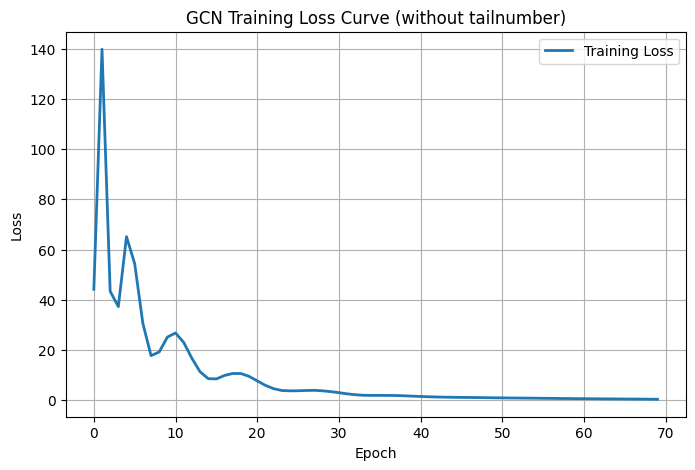

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss Curve (without tailnumber)")
plt.grid(True)
plt.legend()
plt.show()